<a href="https://colab.research.google.com/github/alexlopespereira/mba_enap/blob/main/CD/Notebooks/Aula8_PIB_GeoMunicipios_Bandeiras_ConsumoEnergia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL para carregar as bandeiras dos estados, PIB Percapita, Centróide dos municípios e Consumo de Energia

In [1]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
project_id = 'hardy-messenger-229417'

Authenticated


## 1) Centroides dos municipios

### 1.1) Download do arquivo de Localidades e limpeza/tratamento dos dados.
#### URL do arquivo exportado para xlsx https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/centroide_municipios/BR_Localidades_2010_v1.xlsx

In [4]:
df_xlsx = pd.read_excel('https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/centroide_municipios/BR_Localidades_2010_v1.xlsx', dtype={"CD_GEOCODM,C,20":str})
dfxlsx_geo = df_xlsx[['CD_GEOCODM,C,20','NM_CATEGOR,C,50','LONG,N,24,6','LAT,N,24,6']].rename(columns={'CD_GEOCODM,C,20':"cod_ibge", 'NM_CATEGOR,C,50':"categoria", 'LONG,N,24,6':"long", 'LAT,N,24,6':"lat"})
dfxlsx_geo['categoria'] = dfxlsx_geo['categoria'].str.strip()
dfxlsx_geo = dfxlsx_geo[dfxlsx_geo['categoria']=='CIDADE']
dfxlsx_geo['lat_long'] = dfxlsx_geo[['lat','long']].apply(lambda x: f"{str(x['lat']).replace(',','.')},{str(x['long']).replace(',','.')}", axis=1)
dfxlsx_geo.head()

,cod_ibge,categoria,long,lat,lat_long
0,1100015,CIDADE,-61.999824,-11.935540,"-11.9355403047646,-61.9998238962936"
6,1100023,CIDADE,-63.033269,-9.908463,"-9.9084628665672,-63.0332692780484"
7,1100031,CIDADE,-60.544314,-13.499763,"-13.4997634596963,-60.5443135812009"
9,1100049,CIDADE,-61.442944,-11.433865,"-11.4338650286852,-61.4429442118224"
18,1100056,CIDADE,-60.818426,-13.195033,"-13.1950330320399,-60.8184261646815"


## 2) Join com a tabela de PIB per capita

### 2.1) Criar dataframe do PIB e População

In [2]:

df_pibpercapita = pd.io.gbq.read_gbq('''
SELECT pop.*, dsc.nome_municipio, pib.pib, pib.pib/pop.populacao as pibpercapita FROM `basedosdados.br_ibge_populacao.municipio` pop
LEFT JOIN `basedosdados.br_ibge_pib.municipio` pib on pop.id_municipio = pib.id_municipio and pib.ano = pop.ano
LEFT JOIN (
 select distinct (sc.id_municipio), sc.nome_municipio from `basedosdados.br_geobr_mapas.setor_censitario_2010` sc
 ) as dsc on dsc.id_municipio = pop.id_municipio
''', project_id=project_id)

df_pibpercapita.head()

/tmp/ipython-input-1152503641.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_pibpercapita = pd.io.gbq.read_gbq('''


,ano,sigla_uf,id_municipio,populacao,nome_municipio,pib,pibpercapita
0,1991,RO,1100015,31981,Alta Floresta D'oeste,<NA>,NaN
1,1992,RO,1100015,34768,Alta Floresta D'oeste,<NA>,NaN
2,1993,RO,1100015,37036,Alta Floresta D'oeste,<NA>,NaN
3,1994,RO,1100015,39325,Alta Floresta D'oeste,<NA>,NaN
4,1995,RO,1100015,41574,Alta Floresta D'oeste,<NA>,NaN


### 2.1) Merge do dataframe do centroid com o dataframe do pib percapita

In [6]:
df_merge = df_pibpercapita.merge(dfxlsx_geo[['cod_ibge','lat_long']], how='left', left_on='id_municipio', right_on='cod_ibge')
del df_merge['cod_ibge']
df_merge.head()

,ano,sigla_uf,id_municipio,populacao,nome_municipio,pib,pibpercapita,lat_long
0,1991,RO,1100015,31981,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936"
1,1992,RO,1100015,34768,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936"
2,1993,RO,1100015,37036,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936"
3,1994,RO,1100015,39325,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936"
4,1995,RO,1100015,41574,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936"


## 3) Criar o dataframe das bandeiras

In [7]:
dfb = pd.read_excel("https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/bandeiras/bandeiras.xlsx")
dfb.head()

,ufNome,uf,Bandeira
0,Acre,AC,https://upload.wikimedia.org/wikipedia/commons...
1,Alagoas,AL,https://upload.wikimedia.org/wikipedia/commons...
2,Amapá,AP,https://upload.wikimedia.org/wikipedia/commons...
3,Amazonas,AM,https://upload.wikimedia.org/wikipedia/commons...
4,Bahia,BA,https://upload.wikimedia.org/wikipedia/commons...


In [8]:
dfb['Bandeira'][0]

'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Bandeira_do_Acre.svg/320px-Bandeira_do_Acre.svg.png'

### 3) Fazer o merge com a tabela do pib percapita

In [9]:
df_merge = df_merge.merge(dfb, left_on='sigla_uf', right_on='uf')

### 4) Criar o dataframe de consumo de energia
#### Filtrar pelo tipo de consumo igual a Total

In [10]:
df_energia = pd.io.gbq.read_gbq('''
 SELECT ano, sigla_uf, sum(consumo) as consumo_anual_uf
 FROM `basedosdados.br_mme_consumo_energia_eletrica.uf`
 WHERE tipo_consumo='Total'
 GROUP BY ano, sigla_uf
 ''', project_id=project_id)

df_energia.head()

/tmp/ipython-input-4280177823.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_energia = pd.io.gbq.read_gbq('''


,ano,sigla_uf,consumo_anual_uf
0,2012,PA,16648088
1,2011,PI,2392555
2,2012,RN,4870059
3,2016,PB,5189204
4,2008,PE,9730052


### 5) Join com a tabela fato (PIB, População, Geo, Bandeiras)
#### **Solução**: Adicionar ao modelo o Consumo de Energia somente no 1o registro de cada subgrupo UF/Municipio
#### **Pergunta**: Como identificar o 1o registro de cada subgrupo?
##### **Resposta:** Com a função cumcount (Cumulative Count) do pandas

#### Exemplo da função cumcount com GROUP BY ?
##### Considere o seguinte dataframe fictício com a população dos municípios

In [11]:
df_pop_exemplo = pd.DataFrame([ [2020, 'SP', 10, 'A'], [2020, 'SP', 20, 'B'], [2020, 'SP', 30, 'C'], [2020, 'CE', 5, 'D'], [2020, 'CE', 6, 'E'],  [2020, 'CE', 7, 'F'],  [2020, 'MG', 10, 'H'],
 [2020, 'MG', 11, 'I'], [2020, 'MG', 12, 'J'],   [2021, 'SP', 10, 'A'], [2021, 'SP', 20, 'B'], [2021, 'SP', 30, 'C'], [2021, 'CE', 5, 'D'],
 [2021, 'CE', 6, 'E'],  [2021, 'CE', 7, 'F'],  [2021, 'MG', 10, 'H'], [2021, 'MG', 11, 'I'], [2021, 'MG', 12, 'J'] ], columns = ['Ano', 'UF', 'pop_municipio', 'Municipio'])
df_pop_exemplo.head(12)

,Ano,UF,pop_municipio,Municipio
0,2020,SP,10,A
1,2020,SP,20,B
2,2020,SP,30,C
3,2020,CE,5,D
4,2020,CE,6,E
5,2020,CE,7,F
6,2020,MG,10,H
7,2020,MG,11,I
8,2020,MG,12,J
9,2021,SP,10,A


In [12]:
df_pop_exemplo.groupby(['Ano', 'UF']).cumcount().rename('rank')

,rank
0,0
1,1
2,2
3,0
4,1
5,2
6,0
7,1
8,2
9,0


In [13]:
# Criando uma coluna para guardar o ranking (posição dentro do subgrupo)
df_pop_exemplo['rank'] = df_pop_exemplo.groupby(['Ano', 'UF']).cumcount()
df_pop_exemplo

,Ano,UF,pop_municipio,Municipio,rank
0,2020,SP,10,A,0
1,2020,SP,20,B,1
2,2020,SP,30,C,2
3,2020,CE,5,D,0
4,2020,CE,6,E,1
5,2020,CE,7,F,2
6,2020,MG,10,H,0
7,2020,MG,11,I,1
8,2020,MG,12,J,2
9,2021,SP,10,A,0


#### Considere o dataframe fictício de consumo de energia

In [14]:
df_energia_exemplo = pd.DataFrame([[2020, 'SP', 1000], [2020, 'CE', 50], [2020, 'MG', 100], [2021, 'SP', 1200], [2021, 'CE', 60], [2021, 'MG', 211]], columns = ['Ano', 'UF', 'Consumo'])
df_energia_exemplo

,Ano,UF,Consumo
0,2020,SP,1000
1,2020,CE,50
2,2020,MG,100
3,2021,SP,1200
4,2021,CE,60
5,2021,MG,211


In [15]:
df_energia_exemplo['rank'] = 0
df_energia_exemplo

,Ano,UF,Consumo,rank
0,2020,SP,1000,0
1,2020,CE,50,0
2,2020,MG,100,0
3,2021,SP,1200,0
4,2021,CE,60,0
5,2021,MG,211,0


In [16]:
# Fazer o merge dos dataframes  considerando o ranking como parte da chave
dfm_exemplo = df_pop_exemplo.merge(df_energia_exemplo, on=['Ano','UF','rank'], how='left')
dfm_exemplo.head(12)

,Ano,UF,pop_municipio,Municipio,rank,Consumo
0,2020,SP,10,A,0,1000.0
1,2020,SP,20,B,1,NaN
2,2020,SP,30,C,2,NaN
3,2020,CE,5,D,0,50.0
4,2020,CE,6,E,1,NaN
5,2020,CE,7,F,2,NaN
6,2020,MG,10,H,0,100.0
7,2020,MG,11,I,1,NaN
8,2020,MG,12,J,2,NaN
9,2021,SP,10,A,0,1200.0


### Aplicando essas operações ao dado real de consumo de energia

In [17]:
df_merge2 = df_merge.copy()

In [18]:
df_merge2['rank'] = df_merge2.groupby(['ano', 'sigla_uf']).cumcount()
df_merge2.head(40)

,ano,sigla_uf,id_municipio,populacao,nome_municipio,pib,pibpercapita,lat_long,ufNome,uf,Bandeira,rank
0,1991,RO,1100015,31981,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
1,1992,RO,1100015,34768,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
2,1993,RO,1100015,37036,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
3,1994,RO,1100015,39325,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
4,1995,RO,1100015,41574,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
5,1996,RO,1100015,33471,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
6,1997,RO,1100015,25009,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
7,1998,RO,1100015,24793,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
8,1999,RO,1100015,25025,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0
9,2000,RO,1100015,26533,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0


In [19]:
df_energia2 = df_energia.copy()
df_energia2['rank'] = 0
df_energia2.head()

,ano,sigla_uf,consumo_anual_uf,rank
0,2012,PA,16648088,0
1,2011,PI,2392555,0
2,2012,RN,4870059,0
3,2016,PB,5189204,0
4,2008,PE,9730052,0


In [20]:
df_merge2 = df_merge2.merge(df_energia2, on=['ano','sigla_uf','rank'], how='left')
df_merge2.head(40)

,ano,sigla_uf,id_municipio,populacao,nome_municipio,pib,pibpercapita,lat_long,ufNome,uf,Bandeira,rank,consumo_anual_uf
0,1991,RO,1100015,31981,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
1,1992,RO,1100015,34768,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
2,1993,RO,1100015,37036,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
3,1994,RO,1100015,39325,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
4,1995,RO,1100015,41574,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
5,1996,RO,1100015,33471,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
6,1997,RO,1100015,25009,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
7,1998,RO,1100015,24793,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
8,1999,RO,1100015,25025,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>
9,2000,RO,1100015,26533,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,0,<NA>


### Criando uma função para realizar esta operação de merge

In [21]:
def merge_chave_menor(df_mais_granular, df_menos_granular, chaves_comuns):
  df_mais_granular['rank'] = df_mais_granular.groupby(chaves_comuns).cumcount()
  df_menos_granular['rank'] = 0
  chaves_com_rank = chaves_comuns.append('rank')
  dfr = df_mais_granular.merge(df_menos_granular, on=chaves_com_rank, how='left')
  del dfr['rank']
  return dfr

In [22]:
dfm = merge_chave_menor(df_merge, df_energia, ['ano','sigla_uf'])
dfm.head(40)

,ano,sigla_uf,id_municipio,populacao,nome_municipio,pib,pibpercapita,lat_long,ufNome,uf,Bandeira,consumo_anual_uf
0,1991,RO,1100015,31981,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
1,1992,RO,1100015,34768,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
2,1993,RO,1100015,37036,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
3,1994,RO,1100015,39325,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
4,1995,RO,1100015,41574,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
5,1996,RO,1100015,33471,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
6,1997,RO,1100015,25009,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
7,1998,RO,1100015,24793,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
8,1999,RO,1100015,25025,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>
9,2000,RO,1100015,26533,Alta Floresta D'oeste,<NA>,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,<NA>


### 6) Enviar o dataframe de resultado ao BigQuery.
#### Decida se lhe é conveniente reutilizar a tabela e o data source no Data Studio, ou se deseja criar uma nova tabela e um novo data source.
#### Dica 1: Se esta operação apenas adicionar colunas à tabela, sem remover outras, pode reutilizar a tabela e o data source.
#### Dica 2: Se reutilizar a tabela, atualize os campos do seu data source.


In [23]:
dfm.to_gbq("enapdatasets.pibpercapita",
  project_id=project_id,
  chunksize=40000,
  if_exists='replace',
  )

/tmp/ipython-input-666303411.py:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  dfm.to_gbq("enapdatasets.pibpercapita",
100%|██████████| 1/1 [00:00<00:00, 2460.00it/s]


## Plotando mapa com o Plotnine
#### Meu prompt na perplexity: *eu quero criar um heatmap num mapa de UFs do Brasil. As cores devem ser proporcionais ao valor de um determinado atributo, como por exemplo, população e PIB. como eu posso fazer isso usando o plotnine?*



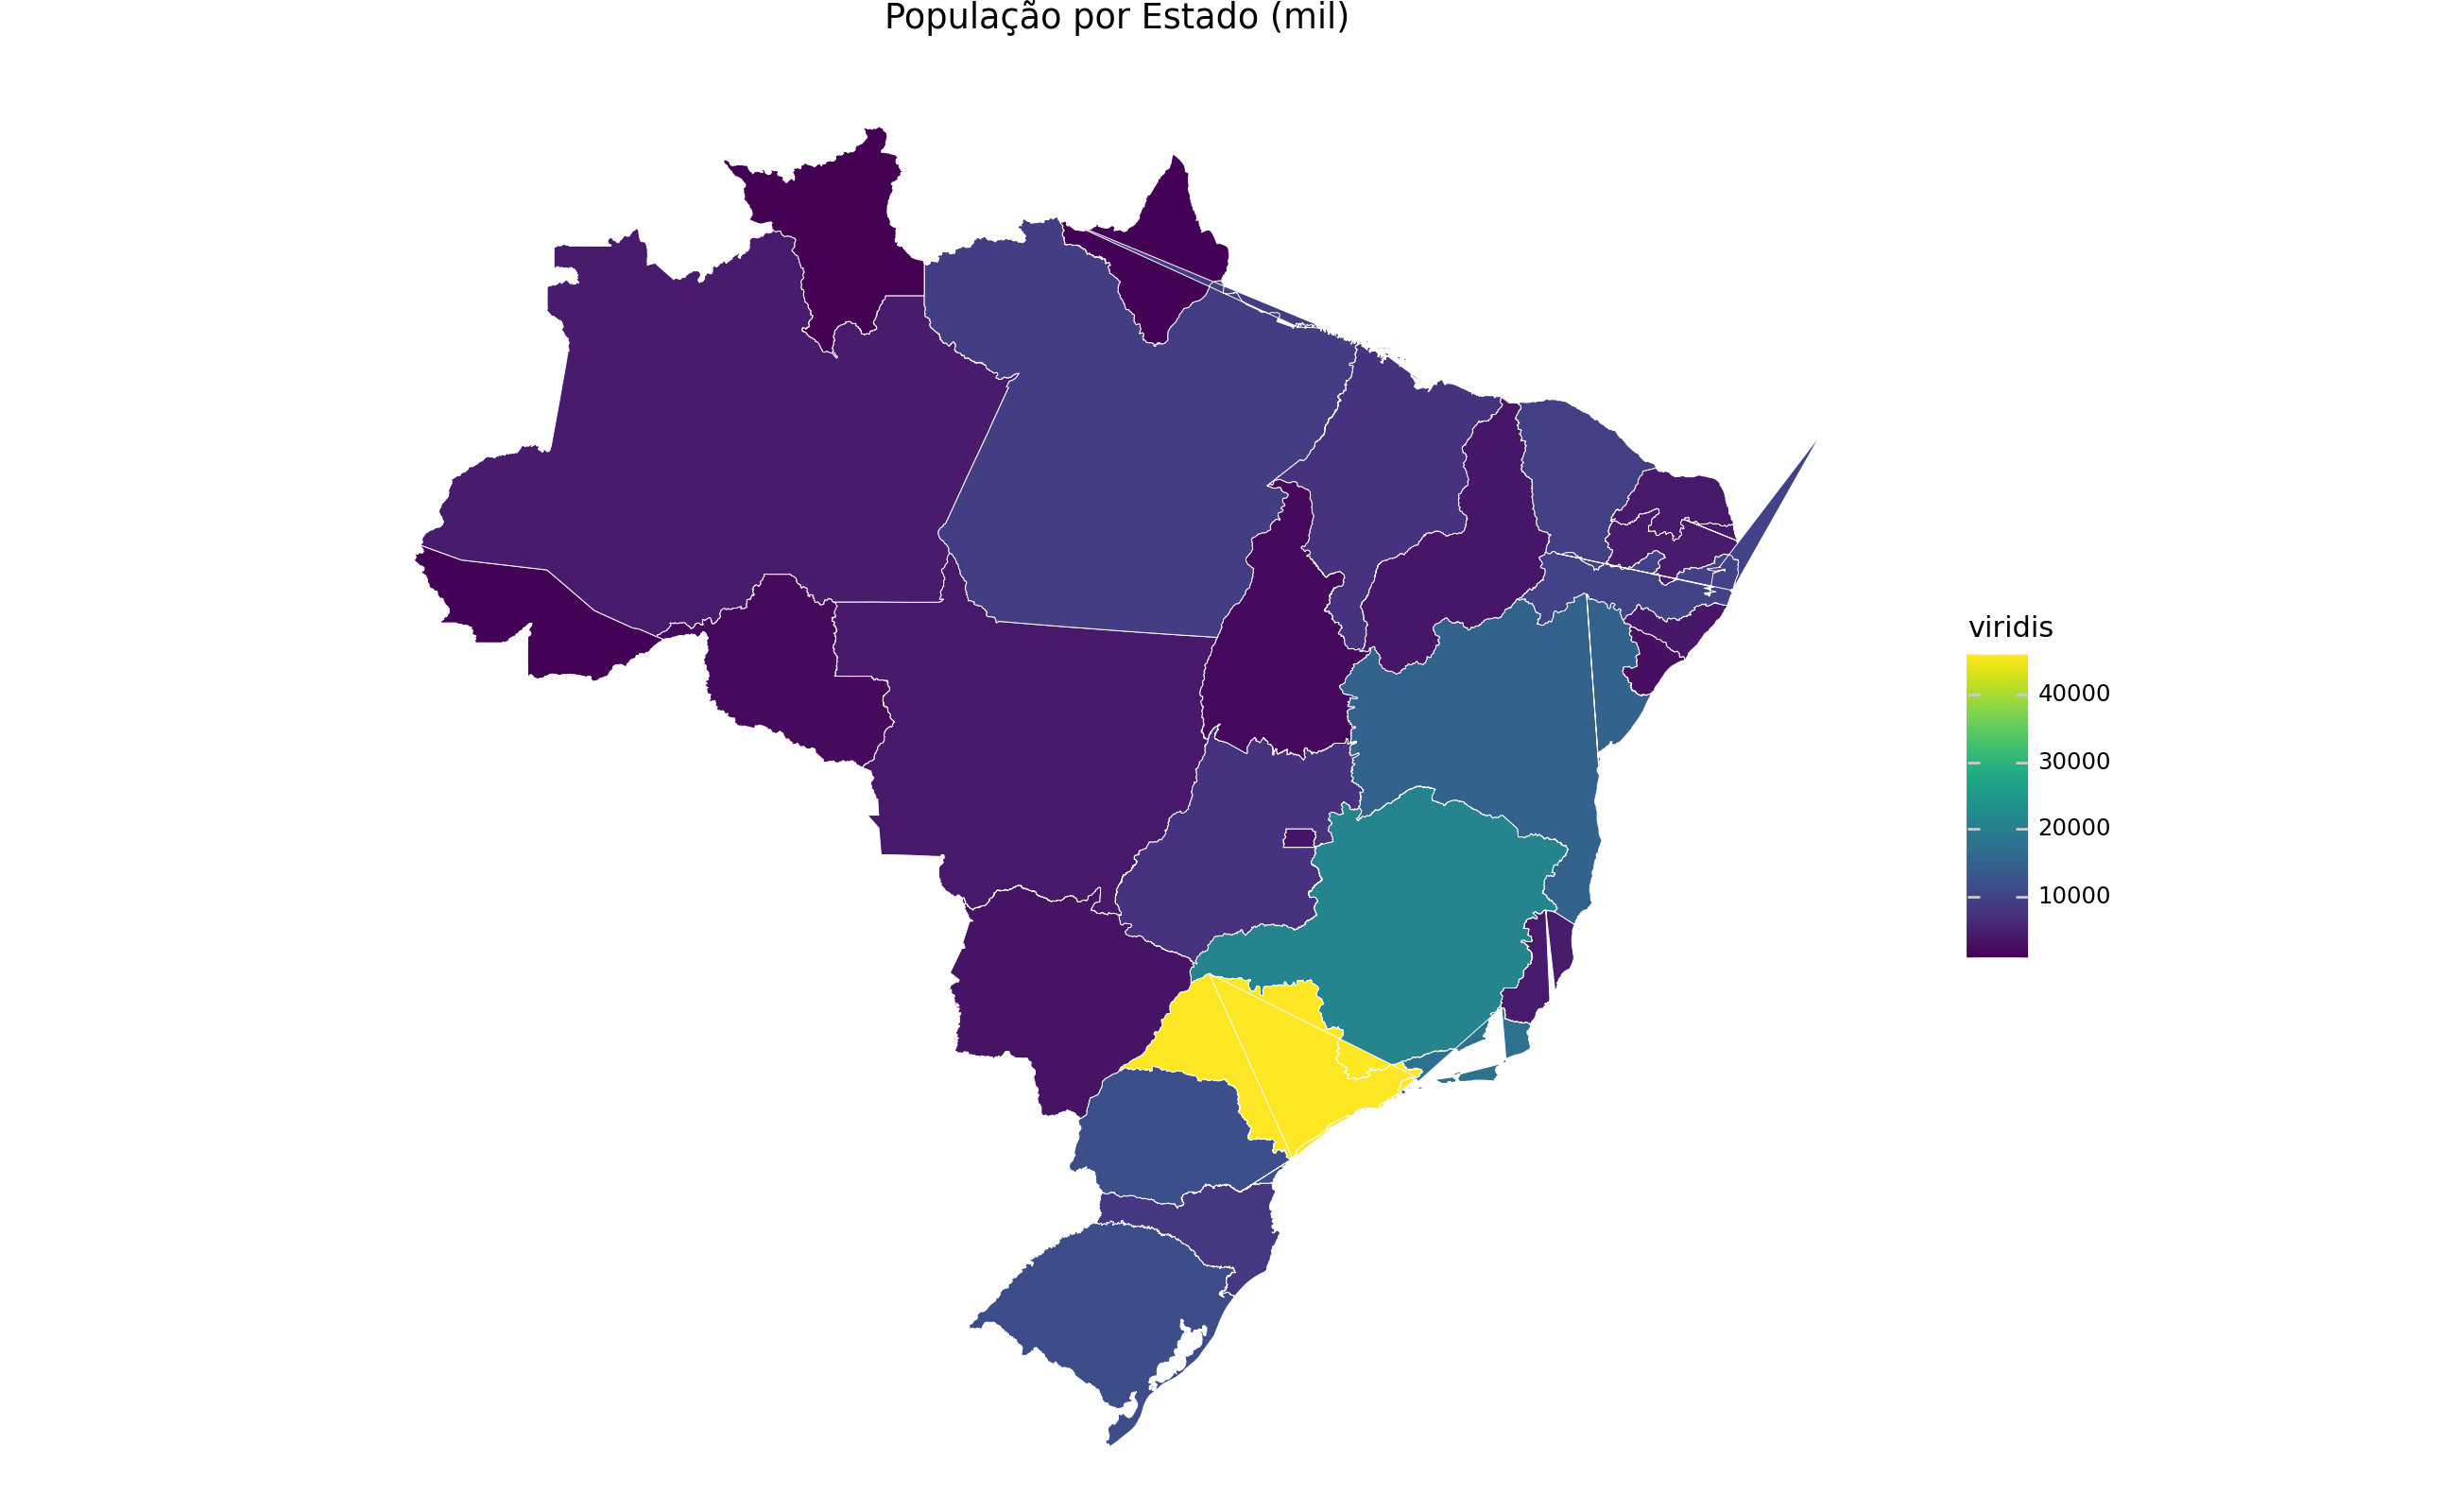

In [20]:
import geopandas as gpd
import pandas as pd
from plotnine import ggplot, aes, geom_polygon, coord_equal, theme_void, scale_fill_cmap, labs, theme

# 1. Carregar o GeoJSON dos estados
gdf = gpd.read_file("https://github.com/giuliano-macedo/geodata-br-states/raw/refs/heads/main/geojson/br_states.json")

# 2. Carregar tabela com o atributo desejado (ou crie um exemplo)
# Exemplo fictício
df = pd.DataFrame({
    'SIGLA': ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SE','SP','TO'],
    'populacao': [907, 3351, 845, 4000, 14873, 9188, 3057, 4017, 7116, 7079, 3564, 2838, 21168, 8691, 4038, 11544, 9616, 3282, 17463, 3567, 11341, 1800, 652, 7810, 2318, 46289, 1607], # mil
    # 'pib': [..], # pode adicionar outro atributo
})

# 3. Fazer o merge
gdf = gdf.merge(df, on="SIGLA", how="left")

# 4. Explode e gera DataFrame de coordenadas para plotnine
gdf_exp = gdf.explode(index_parts=False).reset_index()
poly_rows = []
for idx, row in gdf_exp.iterrows():
    geom = row.geometry
    polys = [geom] if geom.geom_type == "Polygon" else list(geom.geoms)
    for ip, poly in enumerate(polys):
        x, y = poly.exterior.xy
        poly_rows.append({
            'x': x,
            'y': y,
            'group': f"{row['SIGLA']}_{ip}",
            'sigla': row['SIGLA'],
            'populacao': row['populacao']
        })
poly_df = pd.DataFrame([
    {'x': xi, 'y': yi, 'group': d['group'], 'sigla': d['sigla'], 'populacao': d['populacao']}
    for d in poly_rows for xi, yi in zip(d['x'], d['y'])
])

# 5. Plote nas cores do atributo populacao (heatmap choropleth)
p = (
    ggplot(poly_df, aes("x", "y", group="group", fill="populacao")) +
    geom_polygon(color="white", size=0.2) +
    coord_equal() +
    theme_void() +
    scale_fill_cmap(name="viridis") +  # ou name="plasma", "inferno", etc
    labs(title="População por Estado (mil)", fill="População (mil)") +
    theme(figure_size=(13, 8))
)
p


## Validação de dados com a biblioteca Pandera

In [ ]:
!pip install pandera

     |████████████████████████████████| 186 kB 25.3 MB/s 
     |████████████████████████████████| 161 kB 37.8 MB/s 


In [ ]:
dfm.columns.values

array(['ano', 'sigla_uf', 'id_municipio', 'populacao', 'nome_municipio',
       'pib', 'pibpercapita', 'lat_long', 'ufNome', 'uf', 'Bandeira',
       'consumo_anual_uf'], dtype=object)

In [ ]:
import pandera as pa
import pandas as pd
import re
ufs = ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF']

In [ ]:
schema = pa.DataFrameSchema(
    columns={
        'ano': pa.Column(int),
        'sigla_uf': pa.Column(str, checks=[pa.Check.isin(ufs)]),
        'id_municipio': pa.Column(str, nullable=True),
        'populacao': pa.Column(float, nullable=True), 'nome_municipio': pa.Column(str, nullable=True),
       'pib': pa.Column(float, nullable=True),
       'pibpercapita': pa.Column(float, nullable=True),
       'lat_long': pa.Column(str, nullable=True, checks=[pa.Check.str_matches("-?\d*\.\d+\,-?\d*\.\d+")]),
       'ufNome': pa.Column(), 'uf': pa.Column(str), 'Bandeira': pa.Column(str, nullable=True),
       'consumo_anual_uf': pa.Column(float, nullable=True)
        },
        unique=['id_municipio', 'ano']
)

In [ ]:
# re.match("-?\d*\.\d+\,-?\d*\.\d+", "aaaaa-61.9998238962936") #
dfm['sigla_uf'].unique()

array(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF'], dtype=object)

In [ ]:
schema.validate(dfm)

,ano,sigla_uf,id_municipio,populacao,nome_municipio,pib,pibpercapita,lat_long,ufNome,uf,Bandeira,consumo_anual_uf
0,1991,RO,1100015,31981.0,Alta Floresta D'oeste,NaN,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,NaN
1,1992,RO,1100015,34768.0,Alta Floresta D'oeste,NaN,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,NaN
2,1993,RO,1100015,37036.0,Alta Floresta D'oeste,NaN,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,NaN
3,1994,RO,1100015,39325.0,Alta Floresta D'oeste,NaN,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,NaN
4,1995,RO,1100015,41574.0,Alta Floresta D'oeste,NaN,NaN,"-11.9355403047646,-61.9998238962936",Rondônia,RO,https://upload.wikimedia.org/wikipedia/commons...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
168813,2017,DF,5300108,3039444.0,Brasília,2.447222e+11,80515.465768,"-15.794087361891,-47.8879054780313",Distrito Federal,DF,https://upload.wikimedia.org/wikipedia/commons...,6210197.00
168814,2018,DF,5300108,2974703.0,Brasília,2.548172e+11,85661.393656,"-15.794087361891,-47.8879054780313",Distrito Federal,DF,https://upload.wikimedia.org/wikipedia/commons...,6219665.08
168815,2019,DF,5300108,3015268.0,Brasília,NaN,NaN,"-15.794087361891,-47.8879054780313",Distrito Federal,DF,https://upload.wikimedia.org/wikipedia/commons...,6315381.00
168816,2020,DF,5300108,3055149.0,Brasília,NaN,NaN,"-15.794087361891,-47.8879054780313",Distrito Federal,DF,https://upload.wikimedia.org/wikipedia/commons...,6169523.00


In [ ]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168818 entries, 0 to 168817
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ano               168818 non-null  int64  
 1   sigla_uf          168818 non-null  object 
 2   id_municipio      168818 non-null  object 
 3   populacao         168284 non-null  float64
 4   nome_municipio    168768 non-null  object 
 5   pib               94616 non-null   float64
 6   pibpercapita      94615 non-null   float64
 7   lat_long          168768 non-null  object 
 8   ufNome            168818 non-null  object 
 9   uf                168818 non-null  object 
 10  Bandeira          168818 non-null  object 
 11  consumo_anual_uf  486 non-null     float64
dtypes: float64(4), int64(1), object(7)
memory usage: 16.7+ MB
